# Air Quality Analysis 



## 1. Dataset and Knowledge Preparation

The provided dataset contains measurements of air quality from a multisensor device. The device used spectrometer analyzers (variables marked by "GT") and solid state metal oxide detectors (variables marked by "PT08.Sx"), as well as temperature (T), relative humidity (RH) and absolute humidity (AH) sensors. 

The dataset contains 3304 instances of hourly averaged measurements taken at road level in a polluted city. You will predict the CO(GT) variable representing carbon monoxide levels. There are missing features in this dataset, flagged by the number `-999`. 

You will need to pre-process the dataset to handle missing features, for which please self-learn from scikit-learn on how to [impute missing values](https://scikit-learn.org/stable/modules/impute.html). You will need to split the dataset into training and testing sets, also to run cross validation, when you see fit. For this, please self-learn from scikit-learn on [data splitting](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and [cross validation](https://scikit-learn.org/stable/modules/cross_validation.html).   

In [10]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import time

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score
import sklearn.model_selection

notebook_start_time = time.time()

# Import data - it should be saved in the same root directory as this notebook
sensor_data_full = pd.read_excel('sensor_data.xlsx')

# Display a sample of the data
sensor_data_full.sample(5)
binary_targets = (sensor_data_full['CO(GT)'] > 4.5).to_numpy()
sensor_data = sensor_data_full.drop(columns=['CO(GT)']).to_numpy()

## 3. Air Quality Analysis by Neural Network 

In this experiment, you will predict the CO(GT) value based on the other 11 variables through regression. You will use a neural network to build a nonlinear regression model. Familiarise yourself with how to build a regression model by mutlilayer perceptron (MLP) using the scikit learn tutorial (https://scikit-learn.org/stable/modules/neural_networks_supervised.html#regression). 


### 3.1 Simple MLP Model Selection (4 marks)

This section is focused on the practical aspects of MLP implementation and model selection. We will first compare some model architectures. 

The set of MLP architectures to select is specified in `param_grid` below, including two MLPs with one hidden layer, where one has a small number of 3 hidden neurons, while the other has a larger number of 100 hidden neurons, and two MLPs with two hidden layers, where one is small (3, 3) and the other is larger (100, 100). It also includes two activation function options, i.e., the logistic and the rectified linear unit ("relu").  These result in a total of 8 model options, where sklearn default parameters are used for all the MLPs and their training. 

In [11]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV

param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

Your code below should do the following: Split the dataset into the training and testing sets. Preprocess the data by imputing the missing features. Use the training set for model selection by cross-validation, and use mean squared error (MSE) as the model selection performance metric. You can use the scikit-learn module [GridSearchCV](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) to conduct grid search. Print the cross-validation MSE with standard deviation of the selected model. Re-train the selected model using the whole training set, and print its MSE and $R^2$ score for the testing set.  


In [12]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Redo split for regression
train_X_reg, test_X_reg, train_y_reg, test_y_reg = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15)


In [13]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Redo split for regression
train_X_reg, test_X_reg, train_y_reg, test_y_reg = sklearn.model_selection.train_test_split(sensor_data, binary_targets, test_size=0.15)

# Prepare the data (impute missing values)
imputer_reg = SimpleImputer(missing_values=-999, strategy='mean')
train_X_reg = imputer_reg.fit_transform(train_X_reg)
test_X_reg = imputer_reg.transform(test_X_reg)

# Define MLP model
mlp = MLPRegressor(max_iter=200)

# Initialise and fit the grid search
param_grid = [
    {   
        'hidden_layer_sizes': [(3,), (100,), (3, 3), (100, 100)],
        'activation': ['relu', 'logistic'],
    },
]

grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(train_X_reg, train_y_reg)

# Report the best parameters and the CV results
print("Best parameters found:", grid_search.best_params_)
print("Best CV negative mean squared error:", grid_search.best_score_)

# Report model performance
best_model = grid_search.best_estimator_
predictions_test_reg = best_model.predict(test_X_reg)
mse_test = mean_squared_error(test_y_reg, predictions_test_reg)
r2_test = r2_score(test_y_reg, predictions_test_reg)
print("Test Mean Squared Error:", mse_test)
print("Test R^2 Score:", r2_test)


/Users/amineelidrissi/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amineelidrissi/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amineelidrissi/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/amineelidrissi/Library/Python/3.8/lib/python/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

Best parameters found: {'activation': 'logistic', 'hidden_layer_sizes': (100,)}
Best CV negative mean squared error: -0.03635382725820825
Test Mean Squared Error: 0.051297403943599516
Test R^2 Score: 0.32350672052594076


### 3.2 Training Algorithm Comparison: SGD and ADAM (2 Marks)

In this exercise, you will compare two training algorithms, stochastic gradient descent (SGD) and ADAM optimisation, for training an MLP with two hidden layers each containing 100 neurons with "relu" activation, under the settings specified in `test_params` as below.

In [14]:
test_params = [
    {
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'solver': 'adam'
    },{
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    },
]

Write the code below, where each training algorithm should run for 300 iterations (make sure to set `early_stopping=False`). For both algorithms, (1) plot the training loss (use the defaul loss setting in sklearn), as well as the MSE of both training and testing sets, over iterations; and (2) print the MSE and $R^2$ score of the trained model using the testing set. 

ValueError: Found input variables with inconsistent numbers of samples: [496, 2808]

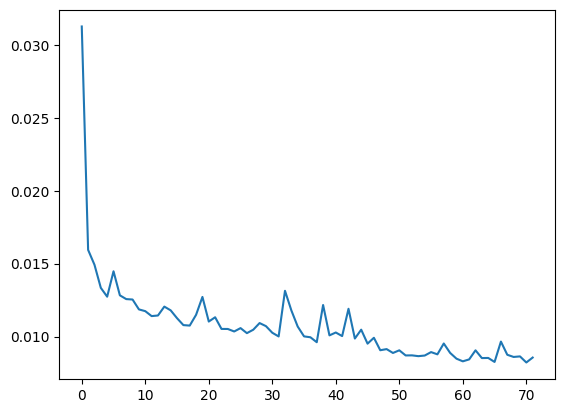

In [15]:
from sklearn.preprocessing import StandardScaler

# Normalize the input features
scaler = StandardScaler()
train_X_reg_scaled = scaler.fit_transform(train_X_reg)
test_X_reg_scaled = scaler.transform(test_X_reg)

# Initialize lists to store MSE for each model
train_mse_adam = []
test_mse_adam = []
train_mse_sgd = []
test_mse_sgd = []

# Train models and plot learning curves
for params in test_params:
    mlp = MLPRegressor(**params, max_iter=300)
    mlp.fit(train_X_reg_scaled, train_y_reg)
    
    # Plot training loss over iterations
    plt.plot(mlp.loss_curve_, label='{} Loss'.format(params['solver']))

    # Calculate MSE for training set
    predictions_train = mlp.predict(train_X_reg_scaled)
    train_mse = mean_squared_error(train_y_reg, predictions_train)
    if params['solver'] == 'adam':
        train_mse_adam.append(train_mse)
        r2_score_adam = r2_score(train_y_reg, predictions_train)
    else:
        train_mse_sgd.append(train_mse)
        r2_score_sgd = r2_score(train_y_reg, predictions_train)
    
    # Calculate MSE for testing set
    predictions_test = mlp.predict(test_X_reg_scaled)
    test_mse = mean_squared_error(test_y_reg, predictions_test)
    if params['solver'] == 'adam':
        test_mse_adam.append(test_mse)
    else:
        test_mse_sgd.append(test_mse)

plt.title('Training Loss Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Print final test set performance for both models
print("Test MSE (adam) : {:.4f}".format(np.mean(test_mse_adam)))
print("Test R^2 Score (adam) : {:.4f}".format(r2_score_adam))
print("Test MSE (sgd) : {:.4f}".format(np.mean(test_mse_sgd)))
print("Test R^2 Score (sgd) : {:.4f}".format(r2_score_sgd))

### 3.3 Report (4 Marks)
Answer the following questions in your report, to be submitted separately:
1. What conclusions can you draw based on your model selection results in Section 3.1? (2 marks)

2. Comment on the two training algorithms based on your results obtained in Section 3.2. (2 marks)

## 4.  Build A Robust MLP Regressor (6 Marks)

In this last experiment, you will develop and submit a robust MLP regressor to predict the CO(GT) value based on the other 11 variables, using the provided dataset. This robust regressor should account for the presence of missing and noisy features. 

Once you have developed your model, save it to a file using the provided `save_model
` function for submission.

### 4.1 Model Development (3 Marks)

What you consider in model development should include (but not limited to) (1) handling of missing features in the unseen testing data, (2) handling of noisy features in the unseen testing data, and (3) a model selection practice.

Write your model development code below. Describe briefly in your report what you have considered in your model development.


In [ ]:
imputer = SimpleImputer(missing_values=-999, strategy='mean')
scaler = sklearn.preprocessing.StandardScaler()
X  = imputer.fit_transform(sensor_data)
X_scaler = scaler.fit_transform(X)
y = binary_targets

In [ ]:
# Best param
best_param={
        'activation': 'relu', 
        'alpha': 0.001, 
        'early_stopping': False, 
        'hidden_layer_sizes': (100, 100), 
        'learning_rate': 'adaptive', 
        'momentum': 0.95, 
        'solver': 'sgd'
    }
# Define MLP regressor
model = MLPRegressor(**best_param,max_iter=1000)
model.fit(X_scaler, y)

MLPRegressor(alpha=0.001, hidden_layer_sizes=(100, 100),
             learning_rate='adaptive', max_iter=1000, momentum=0.95,
             solver='sgd')

## 4.2 External Testing (3 Marks)
Save your trained model for submission, and submit it along with your notebook and report. It will be run and evaluated on a test set unseen by you.

**Important: set your university username (e.g. mbxxabc3) below when saving your model.** Failure to do this correctly would lead to your model not being marked!

In [ ]:
import model_eval_utils

#### SAVE YOUR MODEL
student_username = "y54754ae" # SET YOUR USERNAME HERE
model =model # SET YOUR MODEL HERE
model_eval_utils.save_model(student_username, model)

In [ ]:
print(f"Total notebook run time: {time.time() - notebook_start_time:.0f} seconds")

Total notebook run time: 47 seconds


### Option to test your saved model
Use the `run_model()` function to make sure your saved model can be loaded and run before submitting.

Please note the score returned by `run_model()` is not in any way indicative of your final mark. This is just a simple test to make sure your model can be loaded and run. When testing your model, the GTA will run your model following the practice below, but replacing the bunk_data with the testing data.

In [ ]:
# some bunk data
bunk_data = np.array([[ 1.22400000e+03,  9.97440117e+00,
        9.76666667e+02,  2.50600000e+02,  5.71333333e+02,
        1.30700000e+02,  1.42433333e+03,  1.00166667e+03,
        2.32666664e+01,  3.57999992e+01,  1.00855762e+00],
    [ 9.24250000e+02,   3.97337806e+00,
        7.09250000e+02,  6.30000000e+01,  1.15800000e+03,
        7.50000000e+01,  1.31800000e+03,  6.09750000e+02,
        1.60500000e+01,  4.13500004e+01,  7.48680717e-01],
    [ 8.92000000e+02,  5.06611560e+00,
        7.66750000e+02,  7.10000000e+01,  1.18000000e+03,
        8.40000000e+01,  1.46600000e+03,  6.56750000e+02,
        1.79749999e+01,  5.14499998e+01,  1.05039283e+00]])
bunk_labels = np.array([2. , 1.3, 6.1])

score = model_eval_utils.run_model(student_username, 
                                test_data=bunk_data, 
                                test_labels=bunk_labels, 
                                model_folder=".")

Attempting to load from ....
Loaded ./y54754ae.sav model.
Model score: -2804.2147184840933
